# Data Processing

### Graphs:
- 1. Cum. Mass vs time [groupby year] [per person (divide by num students)]
- 2. 
- 3. 
- 4. 

### subtasks:
- Integrate previous name consolidations

## Imports

In [101]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import numpy as np
import calendar

## Load data file into pandas dataframe

### Download Data from current Google Sheet

In [102]:
import os
import requests
import sys

# sheet view/edit link: https://docs.google.com/spreadsheets/d/1ROWww6f3hB2OObk5Kax_cfIP3lo987lxhInNmToUtCI/edit?resourcekey#gid=549923050
# NEWEST 3d print data https://docs.google.com/spreadsheets/d/1UYjxRt_q7meIHVxc4GUn3_DoRElXlRMey5oqHZZmJsI/edit?usp=sharing
sheet_id = "1ROWww6f3hB2OObk5Kax_cfIP3lo987lxhInNmToUtCI"
old_id = "16gWwdpJz6Tpa92GiV3Jq7wrkmSj5Y4rFsRes-XTiOFQ"
newest_id = "1UYjxRt_q7meIHVxc4GUn3_DoRElXlRMey5oqHZZmJsI"
def getGoogleSeet(spreadsheet_id, outDir, outFile):
  
  url = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv'
  response = requests.get(url)
  if response.status_code == 200:
    filepath = os.path.join(outDir, outFile)
    with open(filepath, 'wb') as f:
      f.write(response.content)
      print('CSV file saved to: {}'.format(filepath))    
  else:
    print(f'Error downloading Google Sheet: {response.status_code}')
    sys.exit(1)


##############################################

outDir = './'

os.makedirs(outDir, exist_ok = True)
filepath = getGoogleSeet(sheet_id, outDir, "data/data_current.csv")
old_filepath = getGoogleSeet(old_id, outDir, "data/data_old_python.csv")
newest_filepath = getGoogleSeet(newest_id, outDir, "data/data_newest.csv")

CSV file saved to: ./data/data_current.csv
CSV file saved to: ./data/data_old_python.csv
CSV file saved to: ./data/data_newest.csv


### Read Data into Pandas Dataframes, clean, concat

In [115]:
def clean_df(df:pd.DataFrame):
    """
    Clean timestamp and print mass columns of dataframe

    Args:
        df (pd.DataFrame): dataframe to clean

    Returns:
        pd.DataFrame: cleaned dataframe
    """

    # convert timestamp column from str to pd.Timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # drop rows with undefined timestamps
    df = df[df["timestamp"].notna()]

    # clean all alphabetic characters from print_mass col and replace empty strings with nan
    # TODO: Fix this regex. High averages in the mass come from removing periods and considering decimal masses as ints
    
    if not is_numeric_dtype(df['mass']):
        # df["mass"] = df["mass"].str.replace(r'[^\d\.]', '', regex=True).replace(r'/(\.\d+)+/', '', regex=True).replace('.','').replace('...','').replace('', np.nan)
        df["mass"] = df["mass"].str.replace(r'\D', '', regex=True).replace('', np.nan)

    df = df[df["mass"].notnull()] # remove any colums with nan print mass
    df["mass"] = df["mass"].astype(float)

    # filter out rediculous masses (10kg)
    df = df[df["mass"] < 10000]

    return df


# read current data from csv
df_curr = pd.read_csv("data/data_current.csv")
# rename and downselect relevant columns
rename_map = {
    "Timestamp": "timestamp",
    "Name": "name",
    "Print Mass (in grams)": "mass",
    "If you chose Class Project, which class? If a Project Team/Club, which group?": "class"
}
df_curr.rename(columns = rename_map, inplace = True)      # rename
df_curr = df_curr[["timestamp", "name", "mass", "class"]] # downselect
# Clean timestamp and print mass columns of dataframe
df_curr = clean_df(df_curr)

print("current data\n", df_curr["mass"].describe())

# read current data from csv
df_newest = pd.read_csv("data/data_newest.csv")
# rename and downselect relevant columns
rename_map = {
    "Start time": "timestamp",
    "Your Name": "name",
    "Print Mass (Grams)": "mass",
    "If applicable, which class, research group, or project team?": "class"
}
df_newest.rename(columns = rename_map, inplace = True)      # rename
df_newest = df_newest[["timestamp", "name", "mass", "class"]] # downselect
# Clean timestamp and print mass columns of dataframe
df_newest = clean_df(df_newest)

print("current data\n", df_curr["mass"].describe())


# read old data from csv
df_old = pd.read_csv("data/data_old_python.csv")
# rename and downselect relevant columns
rename_map = {
    "Print Mass (in grams)": "mass",
    "Timestamp":"timestamp",
    "Your Name":"name",
    
}
df_old.rename(columns = rename_map, inplace = True)      # rename
df_old = df_old[["timestamp", "name", "mass"]] # downselect
df_old.drop(df.tail(4).index, inplace=True)
# Clean timestamp and print mass columns of dataframe
df_old = clean_df(df_old)
print("old data\n", df_old["mass"].describe())


# read veryold data from csv
df_veryold = pd.read_csv("data/3d_very_old.csv")

# rename and downselect relevant columns
rename_map = {
    "print_mass_grams": "mass",
    "name":"name",
    "reason_print":"class"
}
df_veryold.rename(columns = rename_map, inplace = True)      # rename
df_veryold = df_veryold[["timestamp", "name", "mass"]] # downselect , "class"
# Clean timestamp and print mass columns of dataframe
df_veryold = clean_df(df_veryold)


# print("veryold\n", df_veryold["mass"].describe())


#concat all data
df = pd.concat([df_veryold, df_old, df_curr, df_newest])
df.to_csv(path_or_buf="data/rajiv_output.csv")

print(df.describe())

current data
 count    1129.000000
mean       49.713020
std       234.657709
min         0.000000
25%         6.000000
50%        22.000000
75%        51.000000
max      7633.000000
Name: mass, dtype: float64
current data
 count    1129.000000
mean       49.713020
std       234.657709
min         0.000000
25%         6.000000
50%        22.000000
75%        51.000000
max      7633.000000
Name: mass, dtype: float64


C:\Users\jperera1\AppData\Local\Temp\ipykernel_12152\164085626.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


old data
 count    2429.000000
mean       61.056402
std       262.172114
min         0.000000
25%        10.000000
50%        24.000000
75%        51.000000
max      7238.000000
Name: mass, dtype: float64
                           timestamp         mass
count                           7795  7795.000000
mean   2019-01-06 18:33:32.990121984   648.645927
min              2014-10-08 22:02:37     0.000000
25%       2016-02-10 03:09:47.500000    15.000000
50%              2019-09-24 22:52:36    50.000000
75%       2021-11-14 17:53:42.500000   367.500000
max              2023-10-08 14:33:13  9927.000000
std                              NaN  1496.383150


C:\Users\jperera1\AppData\Local\Temp\ipykernel_12152\164085626.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mass"] = df["mass"].str.replace(r'\D', '', regex=True).replace('', np.nan)


## print mass vs time

### Cumulative Mass

C:\Users\jperera1\AppData\Local\Temp\ipykernel_12152\346725844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_print_mass["print_mass_cum"] = df_print_mass["mass"].cumsum()


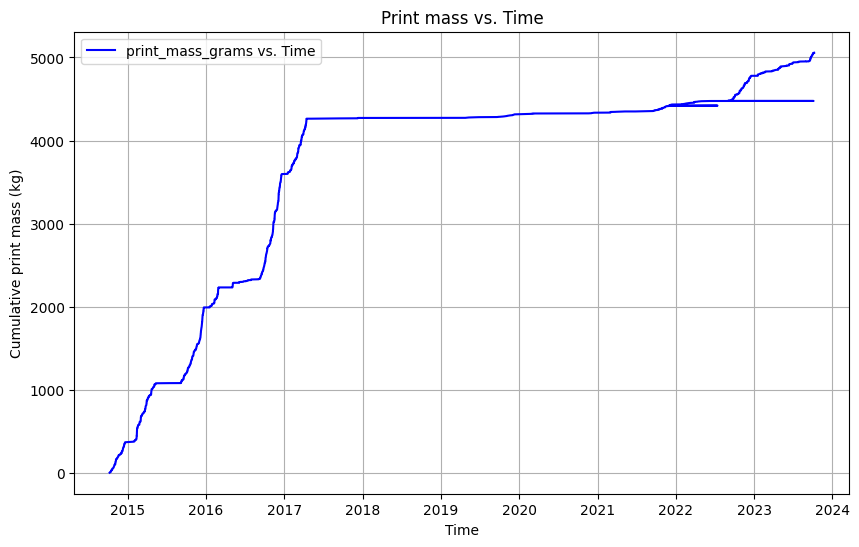

In [116]:
# create new dataframe with copies of timestamp and print_mass_grams columns
df_print_mass = df[["timestamp", "mass"]]

# add column for cumulative sum of print masses
df_print_mass["print_mass_cum"] = df_print_mass["mass"].cumsum()

# Create a line plot using Matplotlib
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(df_print_mass['timestamp'], df_print_mass["print_mass_cum"].div(1000), linestyle='-', color='b', label='print_mass_grams vs. Time')
plt.title("Print mass vs. Time")
plt.xlabel('Time')
plt.ylabel("Cumulative print mass (kg)")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Groupby Year

In [117]:
# function to groupby academic year
def get_academic_year(timestamp:pd.Timestamp):
    """
    Return the academic year string of a timestamp

    Args:
        timestamp (pd.Timestamp): timestamp object

    Returns:
        str: Academic year string, e.g. "21/22"
    """
    year = int(repr(timestamp.year)[-2:]) # lat two digits of year
    if timestamp.month < 9: # before september: year-1/year
        return f"{year-1}/{year}"
    else:                   # after september: year/year+1
        return f"{year}/{year+1}"

def get_semester(timestamp:pd.Timestamp):
    """
    Return the semester string of a timestamp

    Args:
        timestamp (pd.Timestamp): timestamp object

    Returns:
        str: Semester string, e.g. "SP21"
    """
    year = int(repr(timestamp.year)[-2:]) # lat two digits of year
    if timestamp.month < 9: # before september spring semester
        return f"SP {year}"
    else:                   # after september: fall semester
        return f"FA {year}"

# add aacademic year column to df
df["academic year"] = df["timestamp"].apply(lambda x: get_academic_year(x))
df["semester"] = df["timestamp"].apply(lambda x: get_semester(x))


year is 18/19
year is 19/20
year is 20/21
year is 21/22


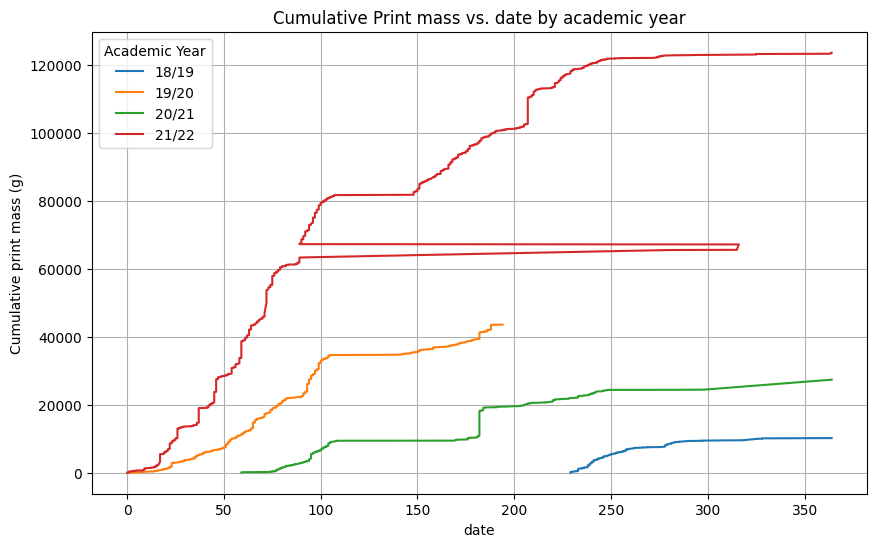

In [118]:
def get_ac_year_day(timestamp: pd.Timestamp):
    """
    Get day of the academic year

    Args:
        timestamp (pd.Timestamp): timestamp to convert
    """
    if timestamp.month >=9:
       return timestamp.day_of_year - 244
    else:
        return timestamp.day_of_year + 365 - 244

# Set up plot
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.title("Cumulative Print mass vs. date by academic year")
plt.xlabel('date')
plt.ylabel("Cumulative print mass (g)")
plt.grid(True)



# group data by academic year
ac_year_groupby = df.groupby('academic year')[["timestamp", "mass"]]

# plot for each academic year on same axes
for ac_year, _df in ac_year_groupby:
    if ac_year in ["14/15", "15/16", "16/17", "17/18", "23/24", "22/23"]:    #"17/18",, "19/20", "18/19", "20/21"
        pass
    else:
        print(f"year is {ac_year}")
        plt.plot(_df["timestamp"].apply(lambda x: get_ac_year_day(x)), _df["mass"].cumsum(), label=f'{ac_year}')
    # print(_df.head())

# Display the plot
plt.legend(title="Academic Year")
plt.show()


### Class/Reason Data Bar Charts

year is 18/19
year is 19/20
year is 20/21
year is 21/22
year is 22/23


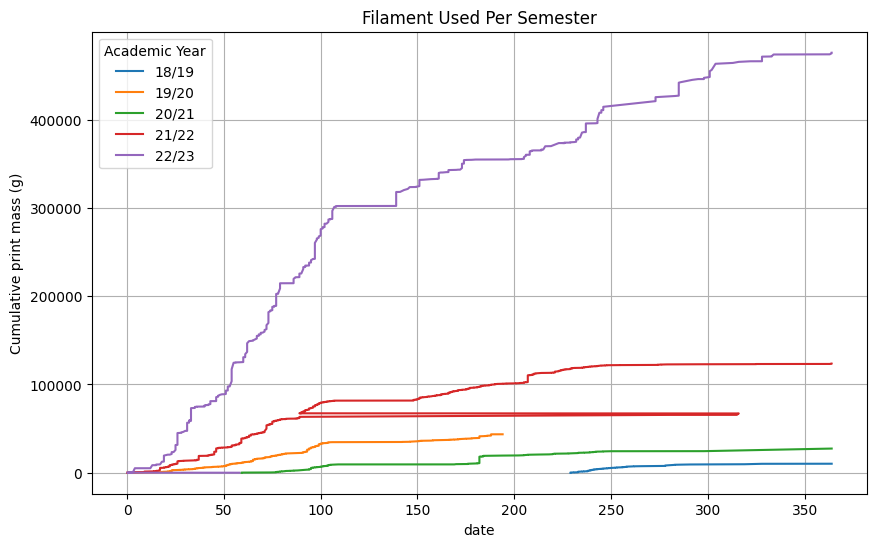

In [124]:
# Set up plot
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.title("Filament Used Per Semester")         # Per reason
plt.xlabel('date')
plt.ylabel("Cumulative print mass (g)")
plt.grid(True)



# group data by academic year
ac_year_groupby = df.groupby('academic year')[["timestamp", "mass"]]

# plot for each academic year on same axes
for ac_year, _df in ac_year_groupby:
    if ac_year in ["14/15", "15/16", "16/17", "17/18", "23/24"]:    #"17/18",, "19/20", "18/19", "20/21", "22/23"
        pass
    else:
        print(f"year is {ac_year}")
        plt.plot(_df["timestamp"].apply(lambda x: get_ac_year_day(x)), _df["mass"].cumsum(), label=f'{ac_year}')
    # print(_df.head())

# Display the plot
plt.legend(title="Academic Year")
plt.show()


## Deal with correcting shitty data (uuuhhhHHH)

In [125]:
def correct_series(series, map:dict):
    """
    Iterate through each correct value in the map dictionary,
    performing a regex string replacement on the series that
    overwrites any matching value with the coorect value given
    by the map

    Args:
        series (pandas series): series to be corrected
        map (dict): dictionary that maps correction keys to 
                    a regex expression targeting incorrect
                    values (<correct value> : <regex query for misnomers>)
    
    Return:
        (pandas series): corrected pandas series
    """
    for correction_key in map:
        series = series.str.replace(map[correction_key], correction_key, regex=True, case=False)
    
    return series

## Deal with class names

In [126]:
class_names = df_curr["class"]

# dictionary for defining name correction map
class_name_map = {
    "DesNat" : "Desnat|desnT|DesNat|dednat|Des Nat|ddesnat|desnat|desNat|Design Nature",
    "Pass. Pursuit" : "passion.*",
    "PIE" : "pie.*",
    "DFM" : "dfm|.*manufact.*",
    "Scope" : ".*scope.*",
    "IS" : ".*indep.*|is.*",
    "Ren. Energy" : ".*renewable.*",
    "EEC" : ".*eec.*",
    "Mech Proto" : ".*proto.*|Mech Proto",
    "QEA" : ".*qea.*",
    "Research" : ".*research.*|.*lair.*",
    "P&M" : ".*market.*|p&.*|p[[:space:]]&.*|p &m",
    "SustDes" : ".*sust.*",
    "RoboSys" : ".*robos.*|.*Robotic System*.",
    "DBF" : ".*dbf.*|design[[:space:]]bu.*",
    "Formula" : "formula",
    "Large 3D Printer" : ".*rint*.",
    "Project Team or Club" : "DBF|Formula|Rocketry|Baja|pint"
}

# correct class names
class_names = correct_series(class_names, class_name_map)

print(len(class_names.unique()), class_names.unique())

69 [nan 'PIE' 'DFM' 'Scope' 'DesNat' 'Iterate' 'Ren. Energy' 'IS' 'EEC'
 'Mech Proto' 'Project Team or Club' 'RoboSys' 'Project Team or Club '
 'Research' 'SustDes' 'QEA' 'RoboSysIntegration' 'STeP'
 'Large 3D Printerr' 'P&M' 'RoboSys Integration' 'Ade' 'Pass. Pursuit'
 'ADE' 'VIS' 'CD' 'MechOriti' 'Mech p' 'Project Team or Club (hydro)'
 'STEP' 'Rocetry' 'RoboGator' 'lorge 3d priter'
 'Project Team or Club organization ' 'Project Team or Club organization'
 'lorge pribter' 'Project Team or Club org' 'Paper Panacea'
 'Mushroom Growing Co-Curricular' 'Paper panacea' 'boca' 'Fun Robo'
 'RoboLab Gator' 'The shop' 'FunRobo' 'The Shop' 'Step' 'Gator RoboLab'
 'Robolab Gator' 'RoboLab Gator ' 'cd' 'Mech Prooto'
 'Collaborative Design' 'mat sci lab' 'hydroponics' 'Large 3D Printerer'
 'Collaborative deIS' 'lorge pruinter' 'Community Art' 'Funrobo'
 'Project jedi ' 'Mech Prot' 'Mech Prot Team 7' 'reaserch' 'OCAP'
 'Shop Summer Fellows' 'Shop Summer Fellow' 'summer shop fellow'
 'Training']


## Deal with student names?

In [127]:
# do later, holy shit